In [5]:
%matplotlib inline

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm as tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import utils
import torch.nn as nn
import numpy as np
import os, imageio

import torch
import cv2

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.1.0.dev20230622+cu121  Device: cuda


In [7]:
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

### Dataloader

In [8]:
def load_image(im_path):

    img = cv2.imread(im_path)

    img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_64F)

    center = [int(img.shape[0]/2),int(img.shape[1]/2)]

    r = 256

    img = img[ center[0]-r:center[0]+r, center[1]-r:center[1]+r]

    return img

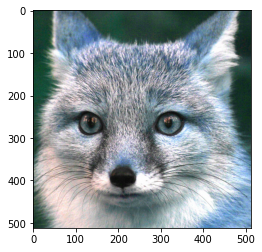

In [11]:
image_url = r"C:/Users/ayush/OneDrive/Desktop/fox.jpg"
img = cv2.imread(image_url)

img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_64F)

center = [int(img.shape[0]/2),int(img.shape[1]/2)]

r = 256

img = img[ center[0]-r:center[0]+r, center[1]-r:center[1]+r]

plt.imshow(img)
plt.show()


### Converting Dataset

In [24]:
def generate_pixel_coordinates(img):
    
    height, width, _ = img.shape

    # Generate coordinates along the x-axis and y-axis
    x_coords = np.linspace(0, 1, width, endpoint=False)
    y_coords = np.linspace(0, 1, height, endpoint=False)

    # Create a meshgrid of coordinates
    x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)
    print(x_mesh.shape,y_mesh.shape)
    # Stack the coordinates and reshape to obtain the final output
    coordinates = np.stack([x_mesh, y_mesh], axis=-1)
    
    return coordinates

### Fourier Feature mapping


In [25]:
def input_mapping(x, B):
    '''
        cos and sin of input are joined together to increased the dimension to 4.
    '''
    if B is None:
        return x
    else:
        B = B.to(x)
        x_proj = (2.*np.pi*x) @ B.T #512,2
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)    #  2*len(B) #512,4

In [26]:
def batch_loader(coord_input,image,map_dict,mapping = 'none'):

    coord_input = input_mapping(coord_input, map_dict[mapping])

    test_data = [coord_input, image]
    train_data = [coord_input[::2], image[::2]]
    
    train_x = torch.tensor(train_data[0])#.reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    train_y = torch.tensor(train_data[1])#.reshape(-1,3)
    test_x = torch.tensor(test_data[0])#.reshape(-1,coord_input.shape[2]) # because input has 4 dimension
    test_y = torch.tensor(test_data[1])#.reshape(-1,3)

    return train_x,train_y,test_x,test_y

### MLP network

In [30]:
class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50) # input has 4 dimensions.
        self.fc1_drop = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(50,3)

    def forward(self, x):
        # x = x.view(-1,4) # input has 4 dimensions.
        x = self.relu1(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.relu2(self.fc2(x))
        x = self.fc2_drop(x)
        return self.fc3(x)

## Train

In [28]:
mapping_size = 64

B_dict = {}
#Standard network - no mapping
# B_dict['none'] = None
# # Basic mapping
# B_dict['basic'] = torch.eye(2)
# # Three different scales of Gaussian Fourier feature mappings
B_gauss = torch.normal(0,1,size=(mapping_size,2))
for scale in [10.]:
    B_dict[f'gauss_{scale}'] = B_gauss * scale

In [29]:
xy_grid = torch.from_numpy(generate_pixel_coordinates(img))

(512, 512) (512, 512)


In [19]:
for k in B_dict:
    keys = k

In [20]:
train_x,train_y,test_x,test_y = batch_loader(xy_grid,img,B_dict,keys)

c:\MLAI\lib\site-packages\torch\utils\_device.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


  0%|          | 0/501 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0, loss = 0.641


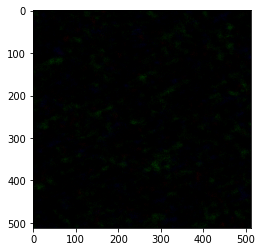

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100, loss = 0.101


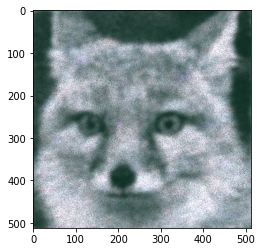

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 200, loss = 0.089


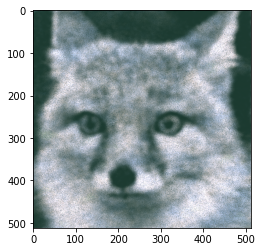

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 300, loss = 0.085


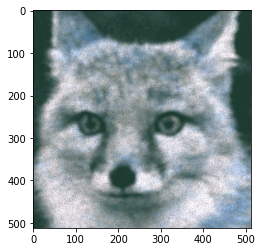

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 400, loss = 0.083


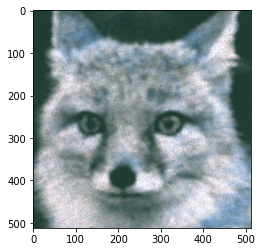

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 500, loss = 0.082


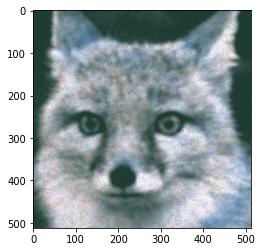

In [23]:

input = test_x.to(device)
target = test_y.to(device)

model = Net(input.shape[2]).to(device)
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-2)


for epoch in tqdm(range(501)):
    optimizer.zero_grad()

    generated = model(input)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      plt.imshow(generated.detach().cpu().numpy())
      plt.show()

### Alternate Networks

!jupyter nbextension enable --py widgetsnbextension

In [17]:
!jupyter nbextension enable --py widgetsnbextension